In [1]:
# load
from google.colab import drive
drive.mount('MyDrive')
%cd "/content/MyDrive/Shareddrives/Project CompBiomed/data"

Drive already mounted at MyDrive; to attempt to forcibly remount, call drive.mount("MyDrive", force_remount=True).
/content/MyDrive/Shareddrives/Project CompBiomed/data


In [2]:
import pandas as pd
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
!pip install wfdb #numpy pandas tqdm seaborn scipy matplotlib scikit-learn Detectors
import wfdb
import glob
import os
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import ast
from scipy.interpolate import interp1d
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda" if torch.cuda.is_available()else"cpu")



# Model

## Definition of the model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv1d(12, 32, kernel_size=32, stride=1,padding =16)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=32, stride=1, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=5, stride=2)

        # Each block repeats this pattern, so they need to be declared separately
        self.conv3 = nn.Conv1d(32, 32, kernel_size=32, stride=1, padding='same')
        self.conv4 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv5 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv6 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv7 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv8 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv9 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')
        self.conv10 = nn.Conv1d(32, 32, kernel_size=16, stride=1, padding='same')

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32*3, 32)  # Update the input features according to the output of the last MaxPool
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.criterion = nn.BCELoss()

    def forward(self, x):
        x = self.conv1(x)
        identity = x

        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = F.relu(x + identity)
        x = self.pool(x)

        for conv in [self.conv4, self.conv6, self.conv8, self.conv10]:
            identity = x
            x = F.relu(conv(x))
            x = conv(x)
            x = F.relu(x + identity)
            x = self.pool(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x


## evaluation functions

In [4]:
from sklearn.metrics import confusion_matrix

# Evaluation function
def evaluate_model_batched(model, dataset, batch_size, device=device):
    model.eval()
    model.to(device)

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, labels in dataset:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predicted = (outputs.squeeze() >= 0.5).float()

            conf_matrix = confusion_matrix(labels.cpu(), predicted.cpu())

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = 100 * total_correct / total_samples
    print(f'Test accuracy: {accuracy:.2f}%')
    return accuracy,conf_matrix


# Data loading

Change target to choose the right binary classification we want

In [5]:
device = torch.device("cuda" if torch.cuda.is_available()else"cpu")
site_1 = "RVOTSEPTUM"
site_2 = "COMMISURE"
site_3 = "RVOT"
site_4 = "LVOT"

########################
target = site_4
########################

loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load('model_' + target + '.pth'))


<All keys matched successfully>

In [6]:
loaded_data = torch.load('data_'+ target+'.pth')

X_train = loaded_data['X_train'].to(device).float()
y_train = loaded_data['y_train'].to(device).float()
patient_train = loaded_data['patient_id_train']

X_test = loaded_data['X_test'].to(device).float()
y_test = loaded_data['y_test'].to(device).float()
patient_test = loaded_data['patient_id_test']

batch_size = 128

# Convert your training and validation data into TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True,drop_last=True)


# Evaluation

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


Test accuracy: 85.13%


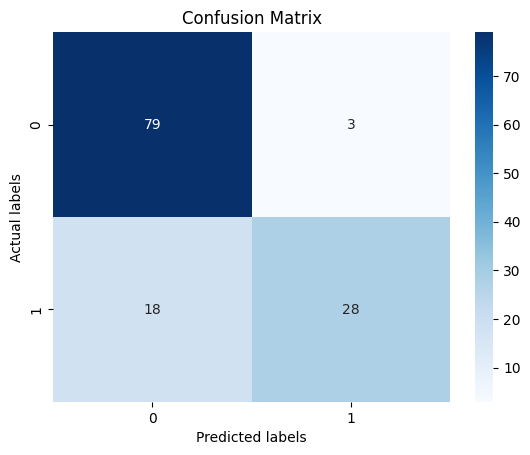

In [7]:
# evaluate_model(model, X_test, y_test)
import seaborn as sns

acc, conf_matrix = evaluate_model_batched(loaded_model, valid_loader, batch_size, device=device)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')

plt.show()